In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:

# =============================================================================
# TASK 1: Baseline Setup
# =============================================================================

print("="*50)
print("TASK 1: Baseline Setup")
print("="*50)

# 1(a) Load pre-trained ResNet-152
def load_pretrained_resnet152():
    """Load pre-trained ResNet-152 from PyTorch"""
    model = torchvision.models.resnet152(pretrained=True)
    return model

# 1(b) Replace final classification layer for CIFAR-10
def modify_resnet_for_cifar10(model, num_classes=10):
    """Modify ResNet-152 for CIFAR-10 classification"""
    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Data loading and preprocessing
def get_cifar10_dataloaders(batch_size=64):
    """Get CIFAR-10 data loaders with appropriate transforms"""

    # Transforms for training and validation
    train_transform = transforms.Compose([
        transforms.Resize(224),  # ResNet expects 224x224 images
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )

    val_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=val_transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

# 1(c) Freeze backbone and train only classification head
def freeze_backbone(model):
    """Freeze all layers except the final classification layer"""
    for name, param in model.named_parameters():
        if 'fc' not in name:  # Freeze everything except final layer
            param.requires_grad = False
        else:
            param.requires_grad = True

    return model

# Training function
def train_model(model, train_loader, val_loader, num_epochs=5, lr=0.001):
    """Train the model and return training history"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        # Calculate metrics
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return model, history

# Initialize and train baseline model
print("Loading pre-trained ResNet-152...")
baseline_model = load_pretrained_resnet152()
baseline_model = modify_resnet_for_cifar10(baseline_model)
baseline_model = freeze_backbone(baseline_model)

print("Loading CIFAR-10 data...")
train_loader, val_loader = get_cifar10_dataloaders()

print("Training baseline model (frozen backbone)...")
baseline_model, baseline_history = train_model(baseline_model, train_loader, val_loader, num_epochs=3)


TASK 1: Baseline Setup
Loading pre-trained ResNet-152...
Loading CIFAR-10 data...
Training baseline model (frozen backbone)...


Epoch 1/3: 100%|██████████| 782/782 [06:23<00:00,  2.04it/s]


Epoch 1: Train Acc: 78.18%, Val Acc: 81.93%


Epoch 2/3: 100%|██████████| 782/782 [06:23<00:00,  2.04it/s]


Epoch 2: Train Acc: 82.05%, Val Acc: 83.10%


Epoch 3/3: 100%|██████████| 782/782 [06:24<00:00,  2.04it/s]


Epoch 3: Train Acc: 82.89%, Val Acc: 83.32%


In [4]:
save_path = "baseline_resnet152.pth"
torch.save(baseline_model.state_dict(), save_path)
print(f"Baseline model weights saved to {save_path}")

Baseline model weights saved to baseline_resnet152.pth


In [6]:

# =============================================================================
# TASK 2: Residual Connections in Practice
# =============================================================================

print("Part 2: Residual Connections ")
print("="*50)

class ModifiedBottleneck(nn.Module):
    """Modified Bottleneck block that can disable skip connections"""
    expansion = 4

    def __init__(self, original_block, disable_skip=False):
        super(ModifiedBottleneck, self).__init__()
        self.conv1 = original_block.conv1
        self.bn1 = original_block.bn1
        self.conv2 = original_block.conv2
        self.bn2 = original_block.bn2
        self.conv3 = original_block.conv3
        self.bn3 = original_block.bn3
        self.relu = original_block.relu
        self.downsample = original_block.downsample
        self.stride = original_block.stride
        self.disable_skip = disable_skip

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if not self.disable_skip:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity

        out = self.relu(out)
        return out

def disable_skip_connections(model, layer_indices_to_modify):
    """Disable skip connections in specified residual blocks"""
    modified_model = copy.deepcopy(model)

    layers = [modified_model.layer1, modified_model.layer2, modified_model.layer3, modified_model.layer4]

    for layer_idx, block_idx in layer_indices_to_modify:
        if layer_idx < len(layers):
            layer = layers[layer_idx]
            if block_idx < len(layer):
                print(f"Disabling skip connection in layer{layer_idx+1}, block {block_idx}")
                original_block = layer[block_idx]
                modified_block = ModifiedBottleneck(original_block, disable_skip=True)
                layer[block_idx] = modified_block
            else:
                print(f"Warning: Block index {block_idx} is out of range for layer{layer_idx+1} (max: {len(layer)-1})")
        else:
            print(f"Warning: Layer index {layer_idx} is out of range (max: {len(layers)-1})")

    return modified_model

print("model with disabled skip, created here")
skip_indices_to_modify = [(1, 2), (2, 3), (3, 4)]  # Disable skip in some middle blocks
modified_model = disable_skip_connections(baseline_model, skip_indices_to_modify)
modified_model = freeze_backbone(modified_model)

print("train without skip connections...")
modified_model, modified_history = train_model(modified_model, train_loader, val_loader, num_epochs=3)

Part 2: Residual Connections 
model with disabled skip, created here
Disabling skip connection in layer2, block 2
Disabling skip connection in layer3, block 3
train without skip connections...


Epoch 1/3: 100%|██████████| 782/782 [06:09<00:00,  2.12it/s]


Epoch 1: Train Acc: 14.90%, Val Acc: 17.54%


Epoch 2/3: 100%|██████████| 782/782 [06:19<00:00,  2.06it/s]


Epoch 2: Train Acc: 18.88%, Val Acc: 21.69%


Epoch 3/3: 100%|██████████| 782/782 [06:18<00:00,  2.06it/s]


Epoch 3: Train Acc: 20.65%, Val Acc: 22.33%


Part 3: Feature Hierarchies and Representations
Extracting features from different layers...
Visualizing features with t-SNE...


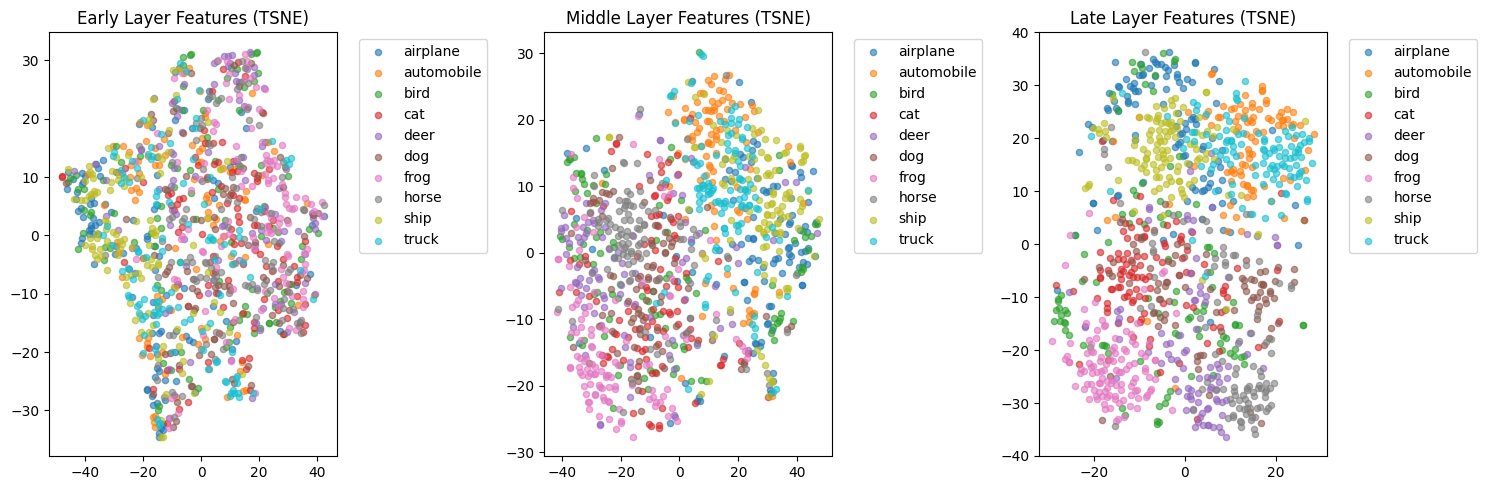

In [7]:

# =============================================================================
# TASK 3: Feature Hierarchies and Representations
# =============================================================================

print("Part 3: Feature Hierarchies and Representations")
print("="*50)

class FeatureExtractor(nn.Module):
    """Extract features from different layers of ResNet"""
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.ModuleDict()

        # Early layers
        self.features['early'] = nn.Sequential(
            model.conv1, model.bn1, model.relu, model.maxpool, model.layer1
        )

        # Middle layers
        self.features['middle'] = nn.Sequential(
            model.layer2, model.layer3
        )

        # Late layers
        self.features['late'] = model.layer4

        # Global average pooling and classifier
        self.avgpool = model.avgpool
        self.fc = model.fc

    def forward(self, x, return_features=False):
        features = {}

        # Early features
        x = self.features['early'](x)
        if return_features:
            features['early'] = x.clone()

        # Middle features
        x = self.features['middle'](x)
        if return_features:
            features['middle'] = x.clone()

        # Late features
        x = self.features['late'](x)
        if return_features:
            features['late'] = x.clone()

        # Final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        if return_features:
            return x, features
        return x

def extract_features_and_labels(model, data_loader, max_samples=1000):
    """Extract features from different layers for visualization"""
    model.eval()

    features_dict = {'early': [], 'middle': [], 'late': []}
    labels = []
    sample_count = 0

    with torch.no_grad():
        for data, targets in data_loader:
            if sample_count >= max_samples:
                break

            data = data.to(device)
            _, features = model(data, return_features=True)

            # Global average pooling for each layer
            for layer_name in features_dict.keys():
                feat = features[layer_name]
                feat = torch.nn.functional.adaptive_avg_pool2d(feat, (1, 1))
                feat = feat.view(feat.size(0), -1)
                features_dict[layer_name].append(feat.cpu().numpy())

            labels.extend(targets.numpy())
            sample_count += data.size(0)

    # Concatenate all features
    for layer_name in features_dict.keys():
        features_dict[layer_name] = np.vstack(features_dict[layer_name])

    return features_dict, np.array(labels)

def visualize_features(features_dict, labels, method='tsne'):
    """Visualize features using t-SNE or UMAP"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    for idx, (layer_name, features) in enumerate(features_dict.items()):
        if method == 'tsne':
            # Apply PCA first to reduce dimensionality
            if features.shape[1] > 50:
                pca = PCA(n_components=50)
                features_reduced = pca.fit_transform(features)
            else:
                features_reduced = features

            embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(features_reduced)
        else:  # UMAP
            embedded = umap.UMAP(n_components=2, random_state=42).fit_transform(features)

        ax = axes[idx]
        for class_idx in range(10):
            mask = labels == class_idx
            ax.scatter(embedded[mask, 0], embedded[mask, 1],
                      c=[colors[class_idx]], label=class_names[class_idx], alpha=0.6, s=20)

        ax.set_title(f'{layer_name.capitalize()} Layer Features ({method.upper()})')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Extract features from baseline model
print("Extracting features from different layers...")
feature_extractor = FeatureExtractor(baseline_model)
features_dict, labels = extract_features_and_labels(feature_extractor, val_loader, max_samples=1000)

print("Visualizing features with t-SNE...")
visualize_features(features_dict, labels, method='tsne')


In [ ]:

# =============================================================================
# TASK 4: Transfer Learning and Generalization
# =============================================================================

print("\n" + "="*50)
print("TASK 4: Transfer Learning and Generalization")
print("="*50)

def get_cifar100_dataloaders(batch_size=64):
    """Get CIFAR-100 data loaders for transfer learning experiment"""

    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=train_transform
    )

    val_dataset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=val_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

def create_transfer_models():
    """Create models for transfer learning comparison"""

    # Model 1: Pre-trained weights, freeze all except final layer
    model_pretrained_frozen = torchvision.models.resnet152(pretrained=True)
    model_pretrained_frozen.fc = nn.Linear(model_pretrained_frozen.fc.in_features, 100)
    model_pretrained_frozen = freeze_backbone(model_pretrained_frozen)

    # Model 2: Pre-trained weights, fine-tune all layers
    model_pretrained_finetune = torchvision.models.resnet152(pretrained=True) # all layers are trainable by default
    model_pretrained_finetune.fc = nn.Linear(model_pretrained_finetune.fc.in_features, 100)
    

    # Model 3: Random initialization
    model_random = torchvision.models.resnet152(pretrained=False)
    model_random.fc = nn.Linear(model_random.fc.in_features, 100)

    # Model 4: Fine-tune only final block
    model_final_block = torchvision.models.resnet152(pretrained=True)
    model_final_block.fc = nn.Linear(model_final_block.fc.in_features, 100)

    # Freeze all except layer4 and fc
    for name, param in model_final_block.named_parameters():
        if 'layer4' not in name and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    return {
        'pretrained_frozen': model_pretrained_frozen,
        'pretrained_finetune': model_pretrained_finetune,
        'random_init': model_random,
        'final_block_only': model_final_block
    }

# Load CIFAR-100 data
print("Loading CIFAR-100 data...")
cifar100_train_loader, cifar100_val_loader = get_cifar100_dataloaders()

# Create transfer learning models
print("Creating transfer learning models...")
transfer_models = create_transfer_models()

# Train and compare models
transfer_results = {}
for model_name, model in transfer_models.items():
    print(f"\nTraining {model_name} model...")

    # Use different learning rates for different setups
    lr = 0.001 if 'random' not in model_name else 0.01

    trained_model, history = train_model(
        model, cifar100_train_loader, cifar100_val_loader,
        num_epochs=3, lr=lr  # Reduced epochs for time
    )

    transfer_results[model_name] = {
        'model': trained_model,
        'history': history
    }



TASK 4: Transfer Learning and Generalization
Loading CIFAR-100 data...


100%|██████████| 169M/169M [00:05<00:00, 29.2MB/s]


Creating transfer learning models...

Training pretrained_frozen model...


Epoch 1/3: 100%|██████████| 782/782 [06:12<00:00,  2.10it/s]


Epoch 1: Train Acc: 51.00%, Val Acc: 59.32%


Epoch 2/3: 100%|██████████| 782/782 [06:25<00:00,  2.03it/s]


Epoch 2: Train Acc: 61.59%, Val Acc: 61.27%


Epoch 3/3: 100%|██████████| 782/782 [06:24<00:00,  2.03it/s]


Epoch 3: Train Acc: 63.80%, Val Acc: 62.81%

Training pretrained_finetune model...


Epoch 1/3: 100%|██████████| 782/782 [18:45<00:00,  1.44s/it]


Epoch 1: Train Acc: 19.74%, Val Acc: 28.32%


Epoch 2/3: 100%|██████████| 782/782 [18:41<00:00,  1.43s/it]


Epoch 2: Train Acc: 43.12%, Val Acc: 47.71%


Epoch 3/3: 100%|██████████| 782/782 [18:38<00:00,  1.43s/it]


Epoch 3: Train Acc: 54.31%, Val Acc: 54.95%

Training random_init model...


Epoch 1/3: 100%|██████████| 782/782 [19:14<00:00,  1.48s/it]


Epoch 1: Train Acc: 3.18%, Val Acc: 5.27%


Epoch 2/3: 100%|██████████| 782/782 [19:15<00:00,  1.48s/it]


Epoch 2: Train Acc: 8.38%, Val Acc: 9.79%


Epoch 3/3: 100%|██████████| 782/782 [19:15<00:00,  1.48s/it]


Epoch 3: Train Acc: 13.98%, Val Acc: 16.54%

Training final_block_only model...


Epoch 1/3: 100%|██████████| 782/782 [07:14<00:00,  1.80it/s]


Epoch 1: Train Acc: 54.64%, Val Acc: 65.56%


Epoch 2/3: 100%|██████████| 782/782 [07:14<00:00,  1.80it/s]


Epoch 2: Train Acc: 70.29%, Val Acc: 69.91%


Epoch 3/3: 100%|██████████| 782/782 [07:14<00:00,  1.80it/s]


Epoch 3: Train Acc: 77.07%, Val Acc: 72.23%


In [11]:
transfer_results.keys()

dict_keys(['pretrained_frozen', 'pretrained_finetune', 'random_init', 'final_block_only'])

In [17]:
transfer_results

{'pretrained_frozen': {'model': ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(



TASK 5: Optional Experiments
Comparing t-SNE vs UMAP for feature visualization...
Visualizing features with UMAP...


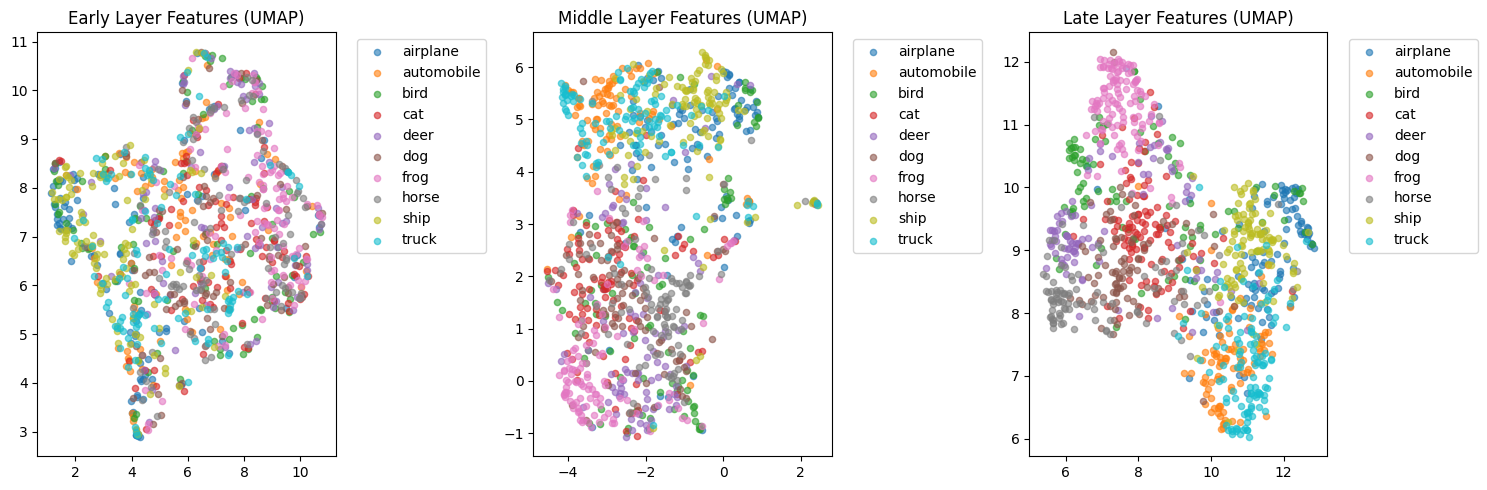

Analyzing confusion patterns...


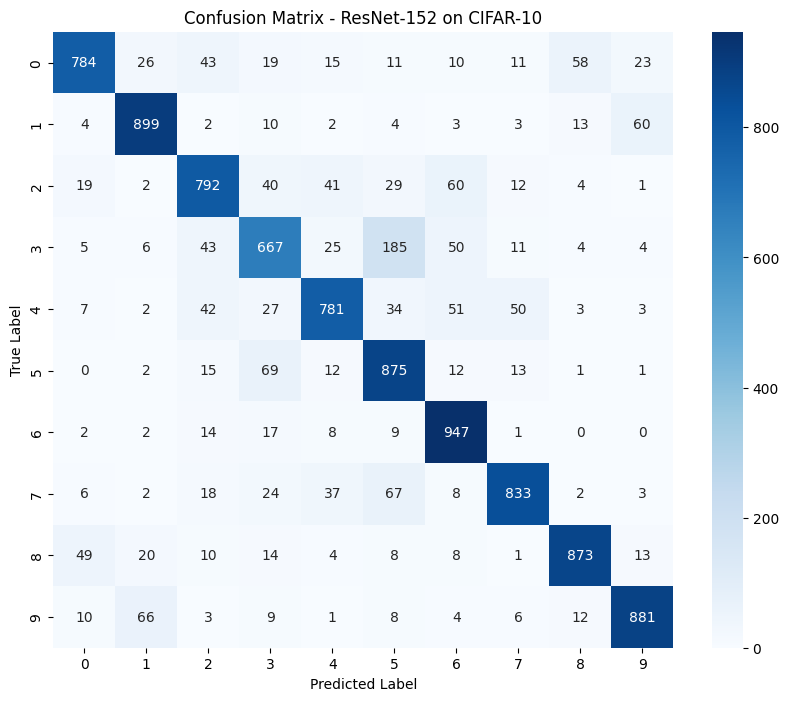

Comparing ResNet-152 vs ResNet-18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Training ResNet-18...


Epoch 1/3: 100%|██████████| 782/782 [01:40<00:00,  7.79it/s]


Epoch 1: Train Acc: 73.29%, Val Acc: 78.71%


Epoch 2/3: 100%|██████████| 782/782 [01:38<00:00,  7.90it/s]


Epoch 2: Train Acc: 78.88%, Val Acc: 80.28%


Epoch 3/3: 100%|██████████| 782/782 [01:38<00:00,  7.96it/s]


Epoch 3: Train Acc: 79.69%, Val Acc: 80.43%

RESULTS VISUALIZATION


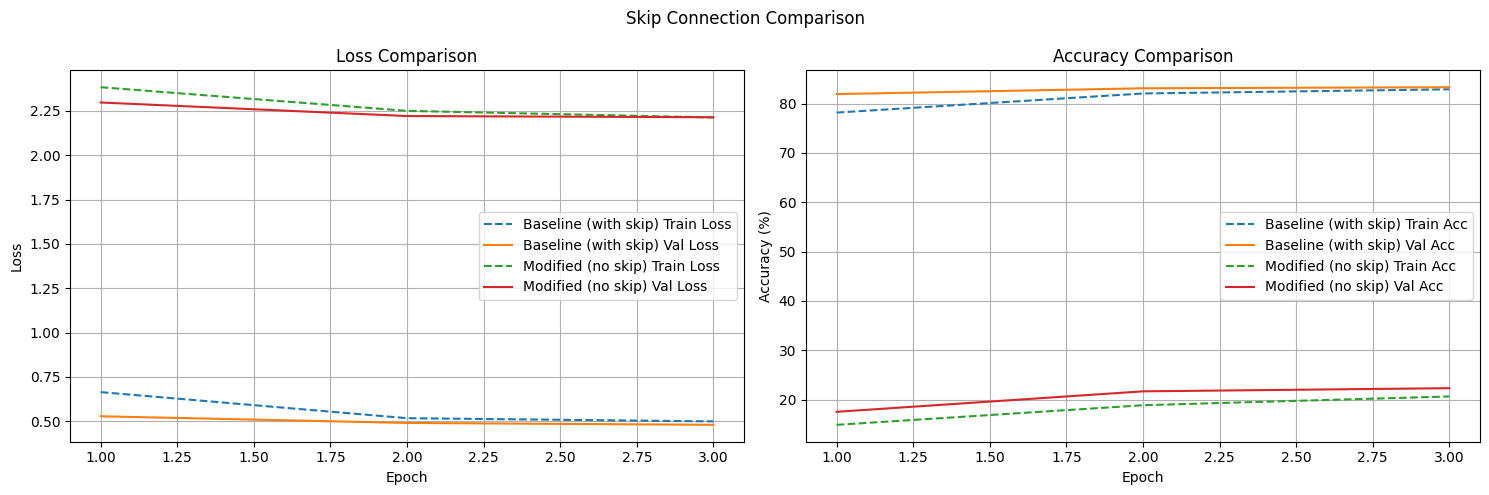

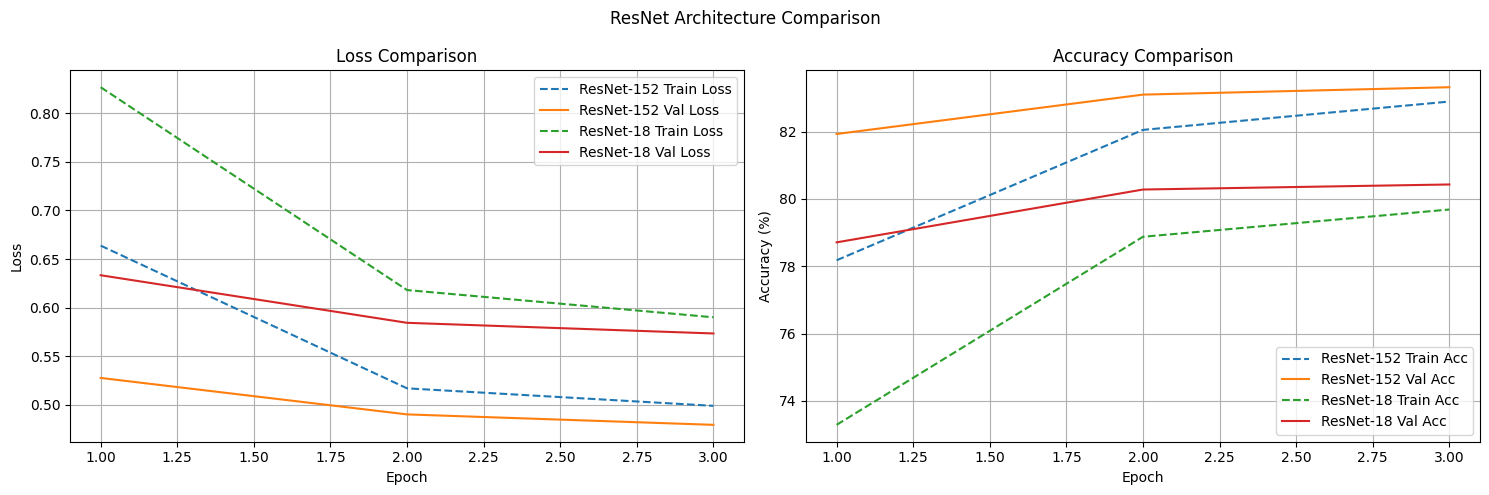

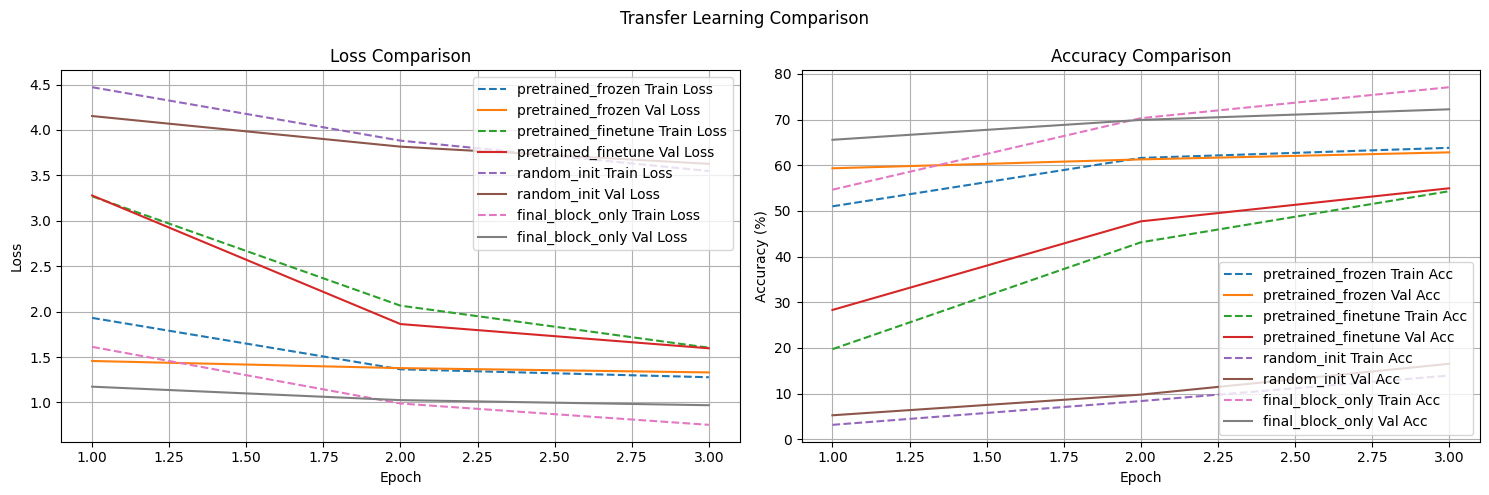

In [18]:

# =============================================================================
# TASK 5: Optional Experiments
# =============================================================================

print("\n" + "="*50)
print("TASK 5: Optional Experiments")
print("="*50)

# 5(a) Compare t-SNE vs UMAP
print("Comparing t-SNE vs UMAP for feature visualization...")
print("Visualizing features with UMAP...")
visualize_features(features_dict, labels, method='umap')

# 5(b) Analyze confusion patterns
def analyze_confusion_matrix(model, data_loader):
    """Analyze which classes the model tends to confuse"""
    from sklearn.metrics import confusion_matrix

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, targets in data_loader:
            data = data.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - ResNet-152 on CIFAR-10')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return cm

print("Analyzing confusion patterns...")
confusion_matrix = analyze_confusion_matrix(baseline_model, val_loader)

# 5(c) Compare ResNet-152 vs ResNet-18
print("Comparing ResNet-152 vs ResNet-18...")

# Load and modify ResNet-18
resnet18_model = torchvision.models.resnet18(pretrained=True)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, 10)
resnet18_model = freeze_backbone(resnet18_model)

print("Training ResNet-18...")
resnet18_model, resnet18_history = train_model(resnet18_model, train_loader, val_loader, num_epochs=3)

# =============================================================================
# RESULTS VISUALIZATION AND COMPARISON
# =============================================================================

print("\n" + "="*50)
print("RESULTS VISUALIZATION")
print("="*50)

def plot_training_history(histories, title="Training History"):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    for name, history in histories.items():
        epochs = range(1, len(history['train_loss']) + 1)

        ax1.plot(epochs, history['train_loss'], label=f'{name} Train Loss', linestyle='--')
        ax1.plot(epochs, history['val_loss'], label=f'{name} Val Loss')

        ax2.plot(epochs, history['train_acc'], label=f'{name} Train Acc', linestyle='--')
        ax2.plot(epochs, history['val_acc'], label=f'{name} Val Acc')

    ax1.set_title('Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot comparison between baseline and modified models
plot_training_history({
    'Baseline (with skip)': baseline_history,
    'Modified (no skip)': modified_history
}, "Skip Connection Comparison")

# Plot ResNet comparison
plot_training_history({
    'ResNet-152': baseline_history,
    'ResNet-18': resnet18_history
}, "ResNet Architecture Comparison")

# Plot transfer learning results
if len(transfer_results) > 0:
    transfer_histories = {name: results['history'] for name, results in transfer_results.items()}
    plot_training_history(transfer_histories, "Transfer Learning Comparison")

print("\n" + "="*50)